In [68]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score
from sklearn.metrics import plot_precision_recall_curve, recall_score
from sklearn.pipeline import Pipeline
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('max_rows',50000)
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from wordcloud import WordCloud
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

[nltk_data] Downloading package stopwords to /Users/niall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/niall/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ModuleNotFoundError: No module named 'wordcloud'

In [69]:
table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer() 
def parseJson(fname):
    for line in open(fname, 'r'):
        yield eval(line)

def to_lower(inp):
    return inp.lower()

def punctuation_lemmatize(inp):
    words = inp.split()
    stripped = [w.translate(table) for w in words]
    stripped = [w for w in stripped if len(w) > 1]
    stripped = [ lemmatizer.lemmatize(w) for w in stripped]    
    return ' '.join(stripped)

def punctuation_stp_words_lemmatize(inp):
    words = inp.split()
    stripped = [w.translate(table) for w in words]
    stripped = [w for w in stripped if len(w) > 1]
    stripped = [w for w in stripped if not w in stop_words]    #uncomment this to remove stop words
    stripped = [ lemmatizer.lemmatize(w) for w in stripped]    
    return ' '.join(stripped)

def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(min_df = 2,max_df = 1.0).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def roc_curve_plot(nb_probs):
    fpr, tpr, _ = roc_curve(y_test, nb_probs)
    plt.plot(fpr, tpr, marker='.', label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
def print_auc_score(nb_probs):
    auc = roc_auc_score(y_test, nb_probs)
    print('AUC: ', auc)
    
def model_analysis(model, model_name, preds, nb_probs):
    average_precision = average_precision_score(y_test, preds)
    print(classification_report(y_test, preds))
    print()
    print(confusion_matrix(y_test, preds))
    print()
    print()
    print(model_name , ' accuracy score: ' , accuracy_score(y_test, preds))
    print(model_name , ' precision score: ' , precision_score(y_test, preds))
    print(model_name , ' recall score: ' , recall_score(y_test, preds))
    print(model_name , ' average precision-recall score: ' , average_precision)
    print()
    
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    

## Load the data

In [70]:
data = list(parseJson('./Sarcasm_Headlines_Dataset.json'))

In [71]:
df = pd.DataFrame(data)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [72]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [73]:
df = df[['is_sarcastic','headline']]
df = shuffle(df)
df.head()

,is_sarcastic,headline
22852,1,horrifying police body camera footage clearly ...
16867,1,tom clancy's death hits cincinnati airport hud...
9599,0,mike huckabee's adele parody is really something
7253,0,people are loving this video of beyoncé and ja...
3632,0,8 common habits that are completely killing th...


In [74]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

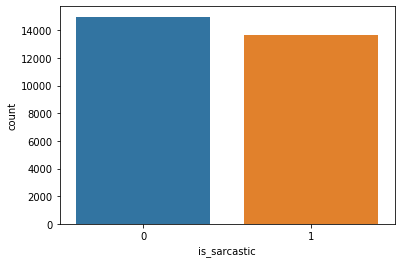

In [13]:
sns.countplot(df.is_sarcastic)

## Processing Data

In [14]:
df['headline'] = df.headline.apply(to_lower)
df['headline'] = df.headline.apply(punctuation_stp_words_lemmatize)

In [15]:
df.head()

,is_sarcastic,headline
25525,1,catching season house card depressingly manage...
22765,0,intuition ego simple step reach truth
11319,1,man worried favorite jedi died seeing obiwan k...
16964,0,john kerry say u negotiate syrian president ba...
7930,0,looked airline pet incident found surprised ev...


## Investigate size of headlines

In [11]:
## Number of words in the text 
df["num_words"] = df["headline"].apply(lambda x: len(str(x).split()))

## Number of characters in the text 
df["num_chars"] = df["headline"].apply(lambda x: len(str(x)))


Text(0.5, 1.0, 'Number of characters')

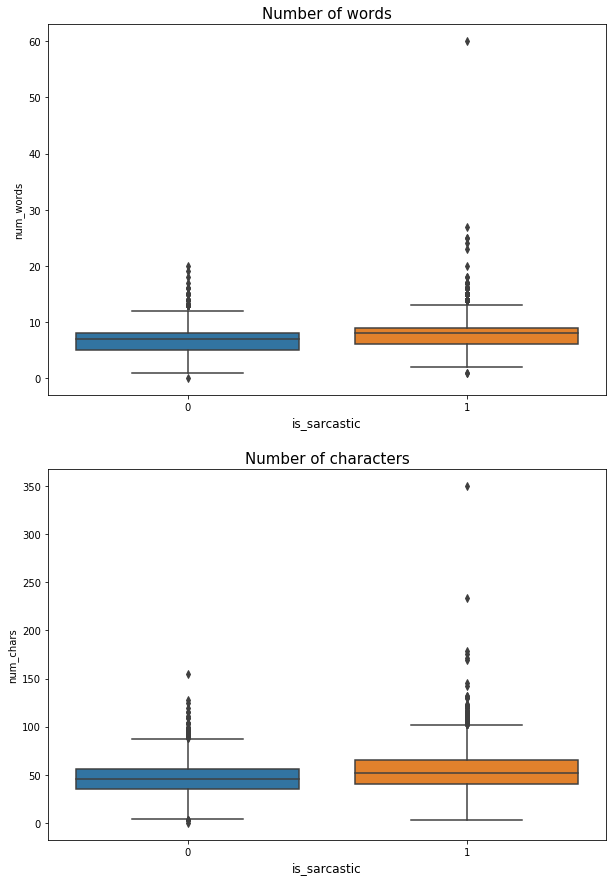

In [12]:
df['num_words'].loc[df['num_words']>60] = 60 
df['num_chars'].loc[df['num_chars']>350] = 350 

f, axes = plt.subplots(2, 1, figsize=(10,15))
sns.boxplot(x='is_sarcastic', y='num_words', data=df, ax=axes[0])
axes[0].set_xlabel('is_sarcastic', fontsize=12)
axes[0].set_title("Number of words", fontsize=15)

sns.boxplot(x='is_sarcastic', y='num_chars', data=df, ax=axes[1])
axes[1].set_xlabel('is_sarcastic', fontsize=12)
axes[1].set_title("Number of characters", fontsize=15)

Text(0.5, 0.98, 'Average word length in each text')

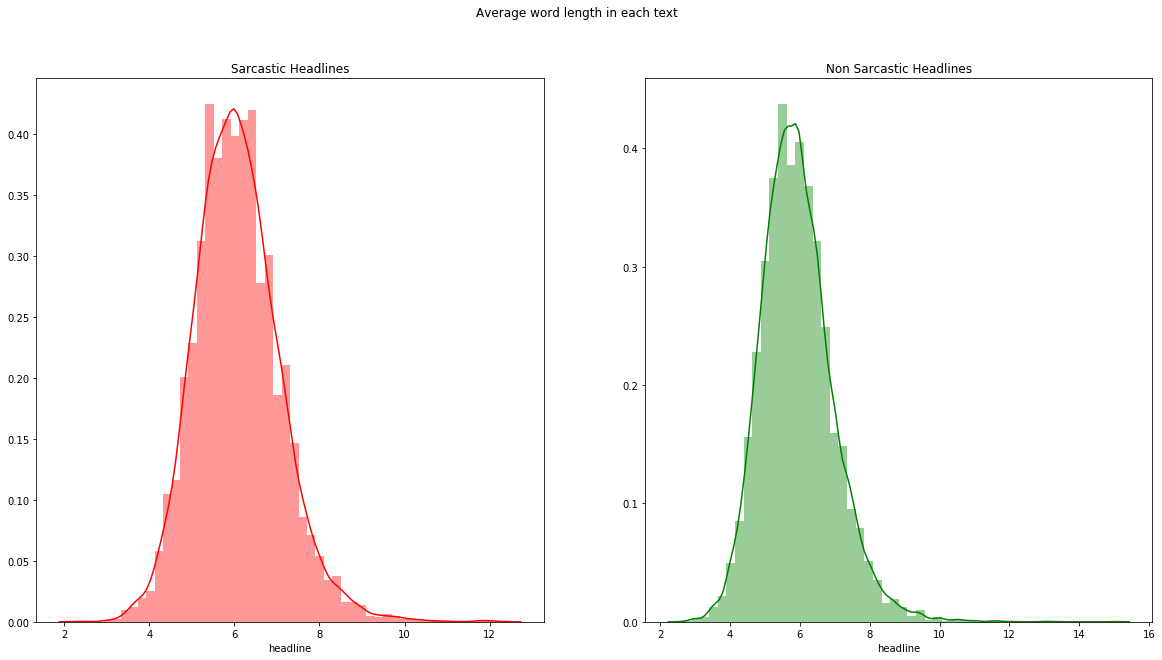

In [13]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(20,10))
word = df[df['is_sarcastic'] == 1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic Headlines')

word = df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Non Sarcastic Headlines')
fig.suptitle('Average word length in each text')

## Create tf-idf

In [16]:
tfidf_vectorizer = TfidfVectorizer(analyzer ='word', encoding= 'utf-8', decode_error = 'ignore', strip_accents='ascii')
X = tfidf_vectorizer.fit_transform(df['headline'])

In [17]:
X.shape

(28619, 25860)

In [18]:
X = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [19]:
y = df['is_sarcastic']

In [20]:
X.shape,y.shape

((28619, 25860), (28619,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(21464, 25860) (21464,)
(7155, 25860) (7155,)


In [23]:
print("Train Data Distribution ")
print(y_train.value_counts(normalize=True))
print("Test Data Distribution ")
print(y_test.value_counts(normalize=True))

Train Data Distribution 
0    0.523388
1    0.476612
Name: is_sarcastic, dtype: float64
Test Data Distribution 
0    0.524249
1    0.475751
Name: is_sarcastic, dtype: float64


In [22]:
train_tmp = X_train

In [23]:
train_tmp.head()

,00000000001,00003,02,03,10,100,1000,10000,100000,1000000,...,zookeeper,zoolander,zoologist,zoomed,zoroastrianism,zsa,zucker,zuckerberg,zuckerbergs,zz
28580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
train_tmp['is_sarcastic'] = y_train
train_tmp.head()

,00000000001,00003,02,03,10,100,1000,10000,100000,1000000,...,zoolander,zoologist,zoomed,zoroastrianism,zsa,zucker,zuckerberg,zuckerbergs,zz,is_sarcastic
28580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
24640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
all_words = pd.DataFrame(train_tmp.sum()).sort_values(0, ascending=False).head(20).reset_index()
all_words.columns = ['Word', 'Frequency']
all_words = all_words.astype({"Frequency": int})

In [26]:
all_words = all_words.iloc[1:]

In [27]:
all_words[:20]

,Word,Frequency
1,trump,246
2,new,235
3,man,224
4,woman,165
5,report,117
6,say,116
7,get,114
8,day,109
9,one,106
10,area,102


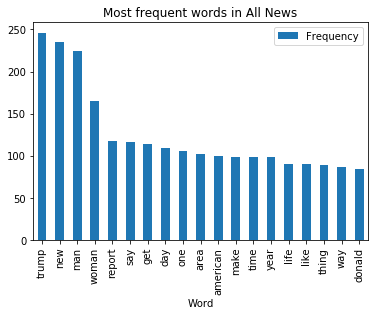

In [28]:
all_words.plot(kind='bar',x='Word',title='Most frequent words in All News')

In [29]:
sarcastic_words = pd.DataFrame(train_tmp[train_tmp['is_sarcastic'] == 1].sum()).sort_values(0, ascending=False).head(21).reset_index()
sarcastic_words = sarcastic_words[sarcastic_words['index'] !='is_sarcastic']
sarcastic_words.columns = ['Word', 'Frequency']
sarcastic_words = sarcastic_words.astype({"Frequency": int})

In [30]:
non_sarcastic_words = pd.DataFrame(train_tmp[train_tmp['is_sarcastic'] == 0].sum()).sort_values(0, ascending=False).head(20).reset_index()
non_sarcastic_words.columns = ['Word', 'Frequency']
non_sarcastic_words = non_sarcastic_words.astype({"Frequency": int})


## Sarcastic Headlines

In [31]:
sarcastic_words[:20]

,Word,Frequency
1,trump,87
2,new,86
3,man,79
4,woman,63
5,say,44
6,report,43
7,year,41
8,get,39
9,area,39
10,one,39


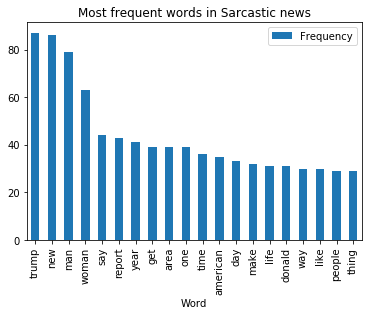

In [32]:
sarcastic_words.plot(kind='bar',x='Word',title='Most frequent words in Sarcastic news')

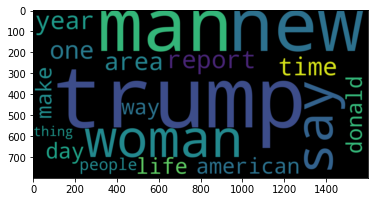

In [33]:
wc_sar = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sarcastic_words.Word))
plt.imshow(wc_sar , interpolation = 'bilinear')

## Non Sarcastic Headlines

In [34]:
non_sarcastic_words[:20]

,Word,Frequency
0,trump,99
1,new,91
2,man,89
3,woman,67
4,day,47
5,get,45
6,say,44
7,report,44
8,make,43
9,american,40


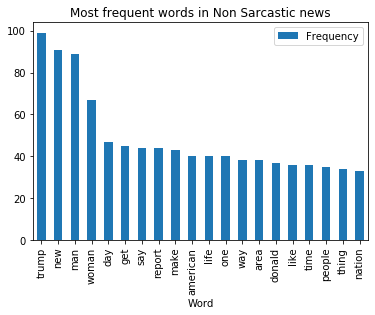

In [35]:
non_sarcastic_words.plot(kind='bar',x='Word',title='Most frequent words in Non Sarcastic news')

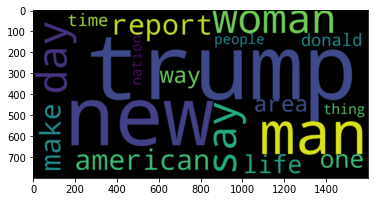

In [36]:
wc_non_sar = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(non_sarcastic_words.Word))
plt.imshow(wc_non_sar , interpolation = 'bilinear')

In [37]:
X_train.drop(columns=['is_sarcastic'],inplace=True)

# masteyr

In [38]:
def save_model(model, name):
    json = model.to_json()
    with open("model.json", "w") as file:
        file.write(json)
    model.save_weights(name , " model.h5")
    print("Saved model to disc")

In [39]:
# Test options and evaluation metric
num_folds = 3
seed = 7
scoring = 'accuracy'

In [40]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('NB', MultinomialNB()))
models.append(('SVM', SVC()))

In [41]:
score_results = []
pred_results = []
names = []
for name, model in models:
    print(name)
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    score_results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    Pkl_Filename = name + "_model.pkl"  

    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(model, file)

LR
LR: 0.776975 (0.001367)
KNN
KNN: 0.666650 (0.023320)
CART
CART: 0.712915 (0.005253)
GNB
GNB: 0.657426 (0.002296)
NB
NB: 0.781588 (0.002561)
SVM
SVM: 0.783964 (0.000502)


In [57]:
score_results[:10]

[array([0.7758211 , 0.77889588, 0.77620911]),
 array([0.64779874, 0.69951083, 0.65264188]),
 array([0.71125087, 0.70747729, 0.72001677]),
 array([0.66051712, 0.65674354, 0.65501817]),
 array([0.78015374, 0.78518519, 0.7794241 ]),
 array([0.78336827, 0.78392732, 0.78459603])]

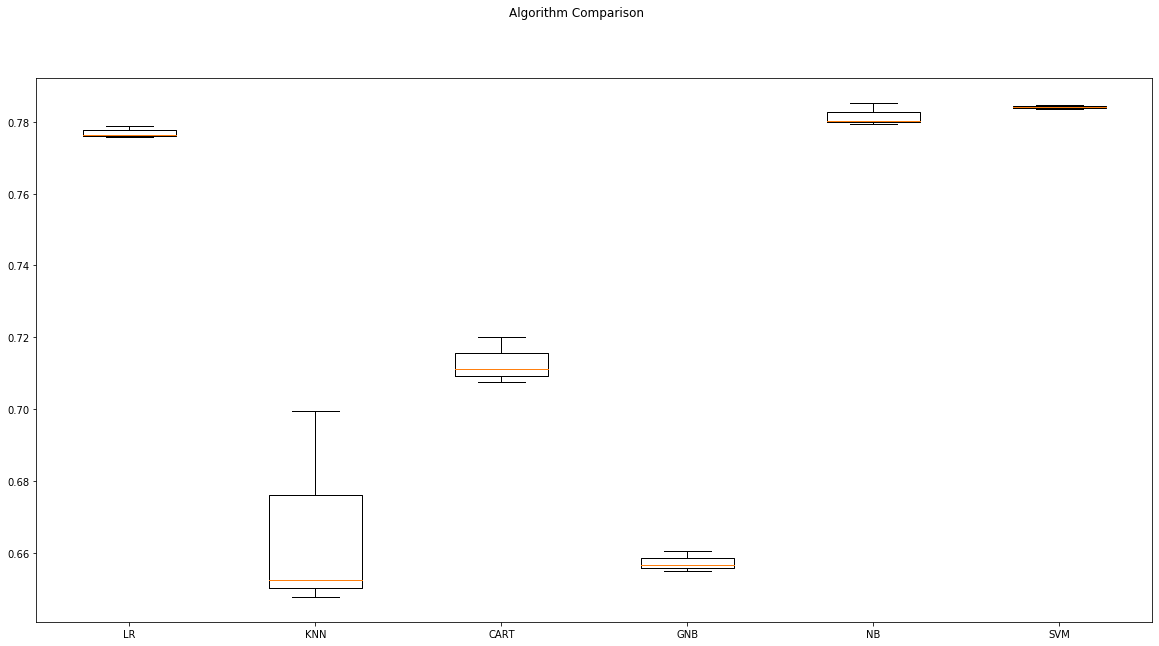

In [47]:
# Compare Algorithms
fig = plt.figure(figsize=(20,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(score_results)
ax.set_xticklabels(names)
plt.show()

In [61]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []

for name, model in ensembles:
    print(name)
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


AB
AB: 0.645546 (0.003833)
GBM
GBM: 0.665812 (0.002889)
RF
RF: 0.756663 (0.004622)
ET
ET: 0.763744 (0.003514)


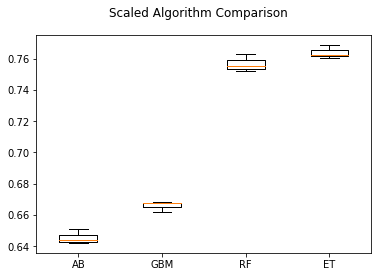

In [62]:
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Fine Tuning Logistic Regression Model

In [29]:
num_folds = 3
seed = 7
scoring = 'accuracy'
penalty = ['l1', 'l2']
c = np.logspace(-4, 4, 20)
solver = ['liblinear', 'lbfgs', 'newton-cg']
param_grid = dict(C=c, penalty=penalty,solver=solver)

model = LogisticRegression()
grid = RandomizedSearchCV(model, param_distributions=param_grid, scoring=scoring, cv=2, n_jobs=-1,verbose=10)
grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  7.3min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.2min finished


In [31]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.770360 using {'solver': 'liblinear', 'penalty': 'l2', 'C': 4.281332398719396}
0.768729 (0.001584) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 11.288378916846883}
0.705507 (0.002562) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.08858667904100823}
nan (nan) with: {'solver': 'lbfgs', 'penalty': 'l1', 'C': 0.615848211066026}
0.770360 (0.000140) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 4.281332398719396}
nan (nan) with: {'solver': 'newton-cg', 'penalty': 'l1', 'C': 545.5594781168514}
nan (nan) with: {'solver': 'newton-cg', 'penalty': 'l1', 'C': 29.763514416313132}
0.739890 (0.000140) with: {'solver': 'liblinear', 'penalty': 'l1', 'C': 78.47599703514607}
0.734998 (0.000839) with: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10000.0}
nan (nan) with: {'solver': 'lbfgs', 'penalty': 'l1', 'C': 78.47599703514607}
nan (nan) with: {'solver': 'lbfgs', 'penalty': 'l1', 'C': 545.5594781168514}


In [35]:
best_LR_predictions = grid_result.predict(X_test)
best_LR_nb_probs = grid_result.predict_proba(X_test)
best_LR_nb_probs = best_LR_nb_probs[:, 1]

## Logistic Regression Tuned Model Analysis

In [46]:
print('LR accuracy score' , accuracy_score(y_test, best_LR_predictions))

LR accuracy score 0.789937106918239


              precision    recall  f1-score   support

           0       0.79      0.82      0.80      3751
           1       0.79      0.75      0.77      3404

    accuracy                           0.79      7155
   macro avg       0.79      0.79      0.79      7155
weighted avg       0.79      0.79      0.79      7155


[[3084  667]
 [ 836 2568]]


Best_LR   accuracy score:  0.789937106918239
Best_LR   precision score:  0.7938176197836166
Best_LR   recall score:  0.754406580493537
Best_LR   average precision-recall score:  0.7157026057480353



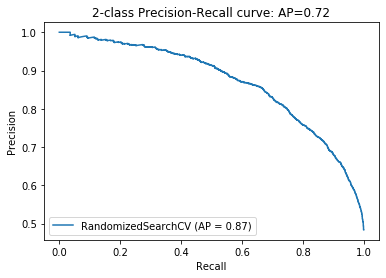

In [44]:
model_analysis(grid_result, 'Best_LR ', best_LR_predictions, best_LR_nb_probs)

AUC:  0.8745138390044676


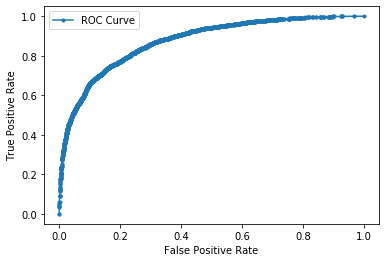

In [45]:
print_auc_score(best_LR_nb_probs)
roc_curve_plot(best_LR_nb_probs)

# Fine tuning Gaussian NB Model

In [56]:
nb_classifier = GaussianNB()
var_smoothing = np.logspace(0,-9, num=100)
param_grid = dict(var_smoothing=var_smoothing)
gs_NB = RandomizedSearchCV(nb_classifier, 
                     param_distributions=param_grid, 
                     cv=2,
                     n_jobs=-1,
                     verbose=10, 
                     scoring='accuracy')

gs_NB.fit(X_train, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 13.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.6min finished


In [57]:
print("Best: %f using %s" % (gs_NB.best_score_, gs_NB.best_params_))
means = gs_NB.cv_results_['mean_test_score']
stds = gs_NB.cv_results_['std_test_score']
params = gs_NB.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.747484 using {'var_smoothing': 0.1873817422860384}
0.660362 (0.002516) with: {'var_smoothing': 1.873817422860383e-06}
0.661619 (0.002749) with: {'var_smoothing': 4.328761281083053e-06}
0.658964 (0.002423) with: {'var_smoothing': 8.111308307896872e-07}
0.747484 (0.000093) with: {'var_smoothing': 0.23101297000831597}
0.747484 (0.000559) with: {'var_smoothing': 0.1873817422860384}
0.660781 (0.002935) with: {'var_smoothing': 2.310129700083158e-06}
0.657240 (0.003401) with: {'var_smoothing': 2.848035868435805e-09}
0.657193 (0.003448) with: {'var_smoothing': 2.310129700083158e-09}
0.657147 (0.003494) with: {'var_smoothing': 6.579332246575682e-09}
0.673779 (0.001584) with: {'var_smoothing': 0.0004328761281083057}


In [63]:
best_GB_predictions = gs_NB.predict(X_test)
best_GB_nb_probs = gs_NB.predict_proba(X_test)
best_GB_nb_probs = best_GB_nb_probs[:, 1]

## Gaussian Tuned Model Analysis

In [64]:
print('GB accuracy score' , accuracy_score(y_test, best_GB_predictions))

GB accuracy score 0.7576519916142558


              precision    recall  f1-score   support

           0       0.71      0.91      0.80      3751
           1       0.85      0.59      0.70      3404

    accuracy                           0.76      7155
   macro avg       0.78      0.75      0.75      7155
weighted avg       0.78      0.76      0.75      7155


[[3401  350]
 [1384 2020]]


Best_GB   accuracy score:  0.7576519916142558
Best_GB   precision score:  0.8523206751054853
Best_GB   recall score:  0.5934195064629847
Best_GB   average precision-recall score:  0.6992148813853677



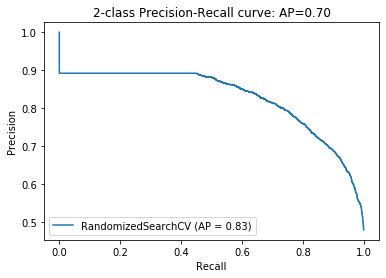

In [65]:
model_analysis(gs_NB, 'Best_GB ', best_GB_predictions, best_GB_nb_probs)

AUC:  0.8635595725197918


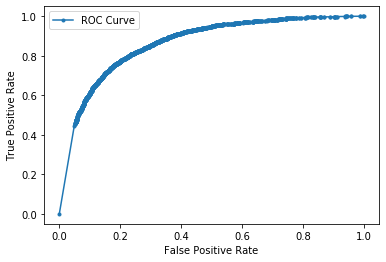

In [67]:
print_auc_score(best_GB_nb_probs)
roc_curve_plot(best_GB_nb_probs)